https://youtu.be/83tnWs_YBRQ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# # # Install the required libraries
# # #SAM
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# # #Transformers
# !pip install -q git+https://github.com/huggingface/transformers.git
# # #Datasets to prepare data and monai if you want to use special loss functions
# !pip install datasets


In [ ]:
# !pip uninstall -y numpy



In [ ]:
# !pip install numpy==2.0.2

# !pip install albumentations

In [ ]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from PIL import Image
from tqdm import tqdm
from statistics import mean

from transformers import SamProcessor
from transformers import SamModel

from datasets import Dataset
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torch.nn.functional import threshold, normalize
import torch.nn.functional as F
from torch.optim import Adam

import albumentations as A



In [ ]:

images_train1_dir = '/content/drive/MyDrive/IT-geo/padded_1024/train/images'
masks_train1_dir = '/content/drive/MyDrive/IT-geo/padded_1024/train/masks'

images_train2_dir = '/content/drive/MyDrive/IT-geo/vessels/images'
masks_train2_dir = '/content/drive/MyDrive/IT-geo/vessels/masks'

# common_files = set(os.listdir(images_train1_dir)) & set(os.listdir(images_train2_dir))
# print(f"Найдено пересечений: {len(common_files)}")

# os.listdir(images_train1_dir)
# os.listdir(images_train2_dir)

image_train1 = sorted([f for f in os.listdir(images_train1_dir) if f.endswith(".npy")])
mask_train1 = sorted([f for f in os.listdir(masks_train1_dir) if f.endswith(".npy")])

image_train2 = sorted([f for f in os.listdir(images_train2_dir) if f.endswith(".npy")])
mask_train2 = sorted([f for f in os.listdir(masks_train2_dir) if f.endswith(".npy")])


dataset = {
    "image": (
        [np.load(os.path.join(images_train1_dir, f)) for f in image_train1] +
        [np.load(os.path.join(images_train2_dir, f)) for f in image_train2][0:16]
    ),
    "label": (
        [np.load(os.path.join(masks_train1_dir, f)) for f in mask_train1] +
        [np.load(os.path.join(masks_train2_dir, f)) for f in mask_train2][0:16]
    )
}

print(len(dataset["image"]), len(dataset["label"]))


48 48


In [ ]:

images_val_dir = '/content/drive/MyDrive/IT-geo/padded_1024/val/images'
masks_val_dir = '/content/drive/MyDrive/IT-geo/padded_1024/val/masks'

image_val = sorted([f for f in os.listdir(images_val_dir) if f.endswith(".npy")])
mask_val = sorted([f for f in os.listdir(masks_val_dir) if f.endswith(".npy")])

val = {
    "image": [np.load(os.path.join(images_val_dir, f)) for f in image_val],
    "label": [np.load(os.path.join(masks_val_dir, f)) for f in mask_val],
}

print(f"Loaded {len(val['image'])} images and {len(val['label'])} masks")


Loaded 5 images and 5 masks


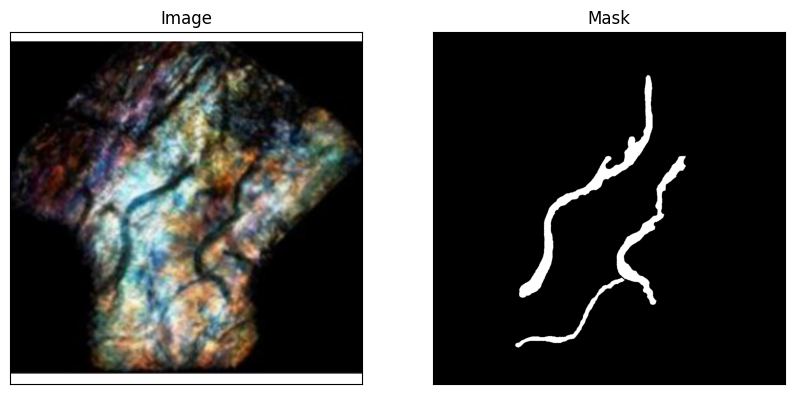

In [ ]:
img_num = random.randint(0, len(image_train1) - 1)
example_image = dataset["image"][img_num]
example_mask = dataset["label"][img_num]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
def get_random_points(ground_truth_map, n):
    y_indices, x_indices = np.where(ground_truth_map > 0)
    height, width = ground_truth_map.shape # Get height and width here

    if len(x_indices) == 0 or len(y_indices) == 0:
        # If no foreground pixels, return the center of the image
        return [[width // 2, height // 2], [width // 2, height // 2], [width // 2, height // 2]]

    # n_points = min(n, len(x_indices))
    random_indices = np.random.choice(len(x_indices), size=n, replace=False)
    final_points = []
    angles_deg = np.arange(0, 180, 30)
    angles_rad = np.radians(angles_deg)

    dirs = list(zip(np.sin(angles_rad), np.cos(angles_rad)))

    for idx in random_indices:
        start_x = x_indices[idx]
        start_y = y_indices[idx]
        min_len = float('inf')
        best_segment = None

        for dy, dx in dirs:
            dist_pos = 0
            cur_x, cur_y = start_x, start_y

            while True:
                next_x = cur_x + dx
                next_y = cur_y + dy
                ix, iy = int(round(next_x)), int(round(next_y))
                if 0 <= ix < width and 0 <= iy < height and ground_truth_map[iy, ix] > 0:
                    cur_x, cur_y = next_x, next_y
                    dist_pos += 1
                else:
                    break
            dist_neg = 0
            cur_x, cur_y = start_x, start_y

            while True:
                next_x = cur_x - dx
                next_y = cur_y - dy
                ix, iy = int(round(next_x)), int(round(next_y))
                if 0 <= ix < width and 0 <= iy < height and ground_truth_map[iy, ix] > 0:
                    cur_x, cur_y = next_x, next_y
                    dist_neg += 1
                else:
                    break
            total_len = dist_pos + dist_neg

            if total_len < min_len:
                min_len = total_len
                p1 = (start_y + dy * dist_pos, start_x + dx * dist_pos)
                p2 = (start_y - dy * dist_neg, start_x - dx * dist_neg)
                best_segment = (p1, p2)

        if best_segment is not None and min_len > 0:
            (y1, x1), (y2, x2) = best_segment
            mid_y = (y1 + y2) / 2
            mid_x = (x1 + x2) / 2
            sigma = min_len / 4.0

            if sigma == 0:
                final_points.append([int(start_x), int(start_y)])
                continue

            offset = np.random.normal(0, sigma)
            vec_y = y1 - y2
            vec_x = x1 - x2
            new_y = mid_y + (vec_y / min_len) * offset
            new_x = mid_x + (vec_x / min_len) * offset
            res_x = int(round(new_x))
            res_y = int(round(new_y))
            final_points.append([res_x, res_y])
        else:
            final_points.append([start_x, start_y])

    return final_points

In [ ]:
def fade(t):
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def lerp(a, b, t):
    return a + t * (b - a)

def gradient(h, x, y):
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

def perlin(x, y, seed=None):
    if seed is not None:
        np.random.seed(seed)
    else:
        np.random.seed(np.random.randint(0, 100000))

    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()

    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi

    u = fade(xf)
    v = fade(yf)

    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)

    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

class PerlinNoise(A.ImageOnlyTransform):
    def __init__(self, scale_range=(5, 20), alpha_range=(0.02, 0.1), always_apply=False, p=0.5):
        super().__init__(always_apply, p)
        self.scale_range = scale_range
        self.alpha_range = alpha_range

    def apply(self, image, **params):
        scale = np.random.uniform(*self.scale_range)
        alpha = np.random.uniform(*self.alpha_range)
        h, w, c = image.shape
        noise = np.zeros((h, w, c))
        for i in range(c):
            xx = np.linspace(0, scale, w)
            yy = np.linspace(0, scale, h)
            x, y = np.meshgrid(xx, yy)
            noise[:, :, i] = perlin(x, y)
        image = image + noise * alpha
        image = np.clip(image, 0, 1)
        return image

class SAMDataset(Dataset):
    """
    This class is used to create a dataset that serves input images and masks.
    It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
    """
    def __init__(self, dataset, processor, mode='train'):
        self.dataset = dataset
        self.processor = processor
        if mode == 'train':
          self.transform = A.Compose([
              A.HorizontalFlip(p=0.5),
              A.VerticalFlip(p=0.5),
              A.RandomRotate90(p=0.5),
              # A.Rotate(limit=(0, 360), border_mode=0, value=(1, 1, 1), mask_value=0.0, p=0.5),
              # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.1, p=0.4),
              # A.GaussNoise(var_limit=(0.0016, 0.04), mean=0, per_channel=True, p=0.3),
              # PerlinNoise(scale_range=(5, 20), alpha_range=(0.02, 0.1), p=0.3),
              # A.GaussianBlur(blur_limit=(3, 7), p=0.2),
          ])
        else:
          self.transform = A.Compose([])

    def __len__(self):
        return len(self.dataset["image"])

    def __getitem__(self, idx):
        image = self.dataset["image"][idx].copy()
        ground_truth_mask = self.dataset["label"][idx].copy()

        # Приведение к стандартному виду (H, W, C) или (H, W)
        if image.ndim == 3 and image.shape[0] == 3:
            image = np.transpose(image, (1, 2, 0))

        if ground_truth_mask.ndim == 3 and ground_truth_mask.shape[0] == 1:
            ground_truth_mask = ground_truth_mask.squeeze(0)

        image = image.astype(np.float32)
        if np.max(image) > 1.0:
            image /= 255.0



        ground_truth_mask = (ground_truth_mask > 0).astype(np.float32)

        augmented = self.transform(image=image, mask=ground_truth_mask)
        image_np = augmented['image']  # (H, W, 3), [0, 1]
        mask_np = augmented['mask']    # (H, W)

        prompt = get_random_points(mask_np, 3)

        image_pil = Image.fromarray(np.clip(image_np * 255, 0, 255).astype(np.uint8))

        inputs = self.processor(image_pil, input_points=[[prompt]], return_tensors="pt", size={"longest_edge": 1024})
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}

        ground_truth_mask_tensor = torch.tensor(mask_np).unsqueeze(0)  # [1, H, W]
        H, W = inputs["pixel_values"].shape[1:]
        ground_truth_mask_tensor = TF.resize(
            ground_truth_mask_tensor,
            size=(H, W),
            interpolation=TF.InterpolationMode.NEAREST
        ).squeeze(0)
        inputs["ground_truth_mask"] = ground_truth_mask_tensor

        return inputs

In [ ]:
def visualize_sam_example(example, image_idx=0):
    """
    Визуализирует изображение с точками промпта и маской
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    pixel_values = example["pixel_values"]  # [3, 1024, 1024]
    input_points = example["input_points"]  # [1, 3, 2]
    ground_truth_mask = example["ground_truth_mask"]  # [1, 512, 512]

    image = pixel_values.permute(1, 2, 0).cpu().numpy()  # [1024, 1024, 3]
    image = (image - image.min()) / (image.max() - image.min())

    # Выводим шейпы в заголовке
    image_shape = image.shape
    axes[0].imshow(image)

    points = input_points.squeeze(0).cpu().numpy()  # [3, 2]
    for i, (x, y) in enumerate(points):
        axes[0].scatter(x, y, c='red', s=50, marker='o', edgecolors='white', linewidths=1)
        axes[0].text(x, y, str(i+1), color='white', fontsize=12,
                    ha='center', va='center', fontweight='bold')
    axes[0].set_title(f"Image with {len(points)} points\nShape: {image_shape}")
    axes[0].axis('off')

    mask = ground_truth_mask.squeeze(0).cpu().numpy()  # [512, 512] вместо [1, 512, 512]
    mask_shape = mask.shape
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title(f"Ground Truth Mask\nShape: {mask_shape}")
    axes[1].axis('off')

    plt.suptitle(f"SAM Dataset Example {image_idx}", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize the processor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The image processor of type `SamImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor, mode='train')
val_dataset = SAMDataset(dataset=val, processor=processor, mode='val')

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_points torch.Size([1, 3, 2])
ground_truth_mask torch.Size([1024, 1024])


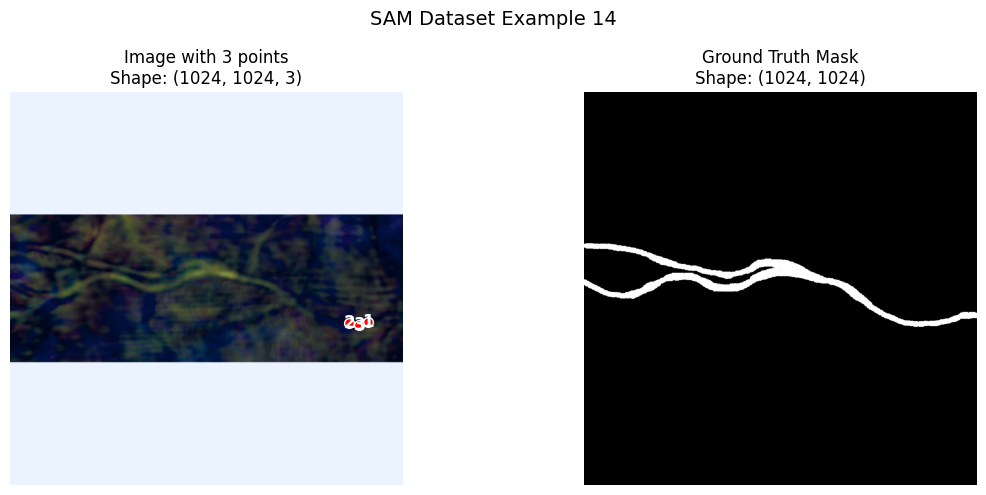

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

visualize_sam_example(example, image_idx=random.randint(1, 20))



In [ ]:
import os
import csv
import matplotlib.pyplot as plt


def plot_metrics(metrics, out_png, out_csv):
    """
    Визуализирует метрики обучения модели
    и сохраняет их в CSV
    """

    epochs = list(range(len(metrics["Train loss"])))

    # ===== SAVE CSV =====
    os.makedirs(os.path.dirname(out_csv), exist_ok=True)

    with open(out_csv, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            "epoch",
            "train_loss",
            "val_loss",
            "precision",
            "recall",
            "iou"
        ])

        for i in epochs:
            writer.writerow([
                i,
                metrics["Train loss"][i],
                metrics["Val loss"][i],
                metrics["Precision"][i],
                metrics["Recall"][i],
                metrics["IoU"][i]
            ])

    # ===== PLOT =====
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    axes[0, 0].plot(epochs, metrics["Train loss"])
    axes[0, 0].set_title("Train Loss")
    axes[0, 0].set_xlabel("Epoch")

    axes[0, 1].plot(epochs, metrics["Val loss"])
    axes[0, 1].set_title("Val Loss")
    axes[0, 1].set_xlabel("Epoch")

    axes[0, 2].plot(epochs, metrics["Precision"])
    axes[0, 2].set_title("Precision")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylim(0, 1)

    axes[1, 0].plot(epochs, metrics["Recall"])
    axes[1, 0].set_title("Recall")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylim(0, 1)

    axes[1, 1].plot(epochs, metrics["IoU"])
    axes[1, 1].set_title("IoU")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylim(0, 1)

    axes[1, 2].axis("off")

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()


In [ ]:
def segmentation_metrics(preds, targets, threshold=0.5, eps=1e-7):
    """
    preds: (B, H, W) — logits или probabilities
    targets: (B, H, W) — {0,1}
    """

    preds = torch.sigmoid(preds)
    preds = (preds > threshold).float()

    targets = targets.float()

    tp = (preds * targets).sum(dim=(1, 2))
    fp = (preds * (1 - targets)).sum(dim=(1, 2))
    fn = ((1 - preds) * targets).sum(dim=(1, 2))

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    iou = tp / (tp + fp + fn + eps)

    return {
        "precision": precision.mean().item(),
        "recall": recall.mean().item(),
        "iou": iou.mean().item()
    }


In [ ]:
def forward_batch(model, batch, device):
    pixel_values = batch["pixel_values"].to(device)
    ground_truth_masks = batch["ground_truth_mask"].float().to(device)

    input_points = batch["input_points"].to(device)
    if input_points.dim() == 3:
        input_points = input_points.unsqueeze(1)

    outputs = model(
        pixel_values=pixel_values,
        input_points=input_points,
        multimask_output=False
    )

    predicted_masks = outputs.pred_masks.squeeze(1)  # [batch, 1, 256, 256]

    predicted_masks = F.interpolate(
        predicted_masks,
        size=(1024, 1024),
        mode="bilinear",
        align_corners=False
    )

    predicted_masks = predicted_masks.squeeze(1)  # [batch, 1024, 1024]

    return predicted_masks, ground_truth_masks

In [ ]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device, epoch):
    model.train()
    losses = []

    for batch in tqdm(dataloader, desc=f"Train {epoch}", leave=False):
        preds, targets = forward_batch(model, batch, device)

        loss = loss_fn(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    return mean(losses)


In [ ]:
@torch.no_grad()
def validate_one_epoch(model, dataloader, loss_fn, device, epoch, threshold=0.5):
    model.eval()

    losses = []
    precisions = []
    recalls = []
    ious = []

    for batch in tqdm(dataloader, desc=f"Val {epoch}", leave=False):
        preds, targets = forward_batch(model, batch, device)

        loss = loss_fn(preds, targets)
        losses.append(loss.item())

        metrics = segmentation_metrics(
            preds,
            targets,
            threshold=threshold
        )

        precisions.append(metrics["precision"])
        recalls.append(metrics["recall"])
        ious.append(metrics["iou"])

    return {
        "loss": mean(losses),
        "precision": mean(precisions),
        "recall": mean(recalls),
        "iou": mean(ious),
    }


In [ ]:
def fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, device, num_epochs, threshold=0.5):

    metrics = {
            "Train loss": [],
            "Val loss": [],
            "Precision": [],
            "Recall": [],
            "IoU": []
    }

    bestIoU = 0

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, loss_fn, device, epoch)
        val_metrics = validate_one_epoch(model, val_dataloader, loss_fn, device, epoch, threshold=threshold)

        metrics["Train loss"].append(train_loss)
        metrics["Val loss"].append(val_metrics["loss"])
        metrics["Precision"].append(val_metrics["precision"])
        metrics["Recall"].append(val_metrics["recall"])
        metrics["IoU"].append(val_metrics["iou"])

        if bestIoU < val_metrics["iou"]:
            bestIoU = val_metrics["iou"]
            torch.save(model.state_dict(), "/content/drive/MyDrive/IT-geo/SEM_1024_paleorusels_vessels_slice.pth")

        print(
            f"\nEPOCH {epoch} | "
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_metrics['loss']:.4f}\n"
            f"Precision: {val_metrics['precision']:.4f} | "
            f"Recall: {val_metrics['recall']:.4f} | "
            f"IoU: {val_metrics['iou']:.4f}"
        )

    return metrics


In [ ]:
def soft_iou_loss(logits, targets, eps=1e-6):
    """
    logits: (B, H, W)
    targets: (B, H, W) in {0,1}
    """
    probs = torch.sigmoid(logits)

    intersection = (probs * targets).sum(dim=(1, 2))
    union = probs.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) - intersection

    iou = (intersection + eps) / (union + eps)
    return 1 - iou.mean()


In [ ]:
class BCETwitterUOLoss(torch.nn.Module):
    def __init__(self, bce_weight=1.0, iou_weight=1.0):
        super().__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.iou_weight = iou_weight

    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        iou = soft_iou_loss(logits, targets)
        return self.bce_weight * bce + self.iou_weight * iou


In [ ]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = BCETwitterUOLoss(bce_weight=1.0, iou_weight=1.0)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=False, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, drop_last=False, num_workers=2)

Loading weights:   0%|          | 0/314 [00:00<?, ?it/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

metrics = fit(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=seg_loss,
    device=device,
    num_epochs=25
)



EPOCH 0 | Train loss: 1.0940 | Val loss: 1.0114
Precision: 0.4161 | Recall: 0.7082 | IoU: 0.2843



EPOCH 1 | Train loss: 0.9182 | Val loss: 0.9231
Precision: 0.7646 | Recall: 0.3808 | IoU: 0.3355



EPOCH 2 | Train loss: 0.9138 | Val loss: 0.9332
Precision: 0.4499 | Recall: 0.8099 | IoU: 0.3436



EPOCH 3 | Train loss: 0.7966 | Val loss: 0.8536
Precision: 0.4334 | Recall: 0.7200 | IoU: 0.3272



EPOCH 4 | Train loss: 0.7524 | Val loss: 0.4786
Precision: 0.7588 | Recall: 0.8045 | IoU: 0.6381



EPOCH 5 | Train loss: 0.7381 | Val loss: 0.8772
Precision: 0.4379 | Recall: 0.7798 | IoU: 0.3355



EPOCH 6 | Train loss: 0.7121 | Val loss: 0.5763
Precision: 0.7138 | Recall: 0.7761 | IoU: 0.5865



EPOCH 7 | Train loss: 0.6926 | Val loss: 0.6866
Precision: 0.6883 | Recall: 0.5870 | IoU: 0.4700



EPOCH 8 | Train loss: 0.6902 | Val loss: 0.7182
Precision: 0.6492 | Recall: 0.6553 | IoU: 0.4861



EPOCH 9 | Train loss: 0.7139 | Val loss: 0.7392
Precision: 0.5822 | Recall: 0.7870 | IoU: 0.4907



EPOCH 10 | Train loss: 0.6738 | Val loss: 0.7208
Precision: 0.5961 | Recall: 0.6128 | IoU: 0.4344



EPOCH 11 | Train loss: 0.6796 | Val loss: 0.4982
Precision: 0.7329 | Recall: 0.7887 | IoU: 0.6260



EPOCH 12 | Train loss: 0.6600 | Val loss: 0.6040
Precision: 0.7627 | Recall: 0.7501 | IoU: 0.5904



EPOCH 13 | Train loss: 0.6582 | Val loss: 0.7083
Precision: 0.6262 | Recall: 0.6781 | IoU: 0.4888



EPOCH 14 | Train loss: 0.6362 | Val loss: 0.7563
Precision: 0.5955 | Recall: 0.7795 | IoU: 0.4854



EPOCH 15 | Train loss: 0.6263 | Val loss: 0.4903
Precision: 0.7852 | Recall: 0.7698 | IoU: 0.6346



EPOCH 16 | Train loss: 0.6195 | Val loss: 0.6902
Precision: 0.7203 | Recall: 0.6321 | IoU: 0.5115



EPOCH 17 | Train loss: 0.6372 | Val loss: 0.8945
Precision: 0.4278 | Recall: 0.7255 | IoU: 0.3406



EPOCH 18 | Train loss: 0.6151 | Val loss: 0.4770
Precision: 0.7726 | Recall: 0.7985 | IoU: 0.6484



EPOCH 19 | Train loss: 0.6263 | Val loss: 0.7316
Precision: 0.6301 | Recall: 0.6497 | IoU: 0.4684



EPOCH 20 | Train loss: 0.6063 | Val loss: 0.8195
Precision: 0.5370 | Recall: 0.7285 | IoU: 0.4286



EPOCH 21 | Train loss: 0.6040 | Val loss: 0.8260
Precision: 0.7187 | Recall: 0.4960 | IoU: 0.4099



EPOCH 22 | Train loss: 0.6066 | Val loss: 0.5077
Precision: 0.7173 | Recall: 0.8279 | IoU: 0.6325



EPOCH 23 | Train loss: 0.5928 | Val loss: 0.5585
Precision: 0.7947 | Recall: 0.7221 | IoU: 0.6148



EPOCH 24 | Train loss: 0.6105 | Val loss: 0.6838
Precision: 0.7069 | Recall: 0.5646 | IoU: 0.4728


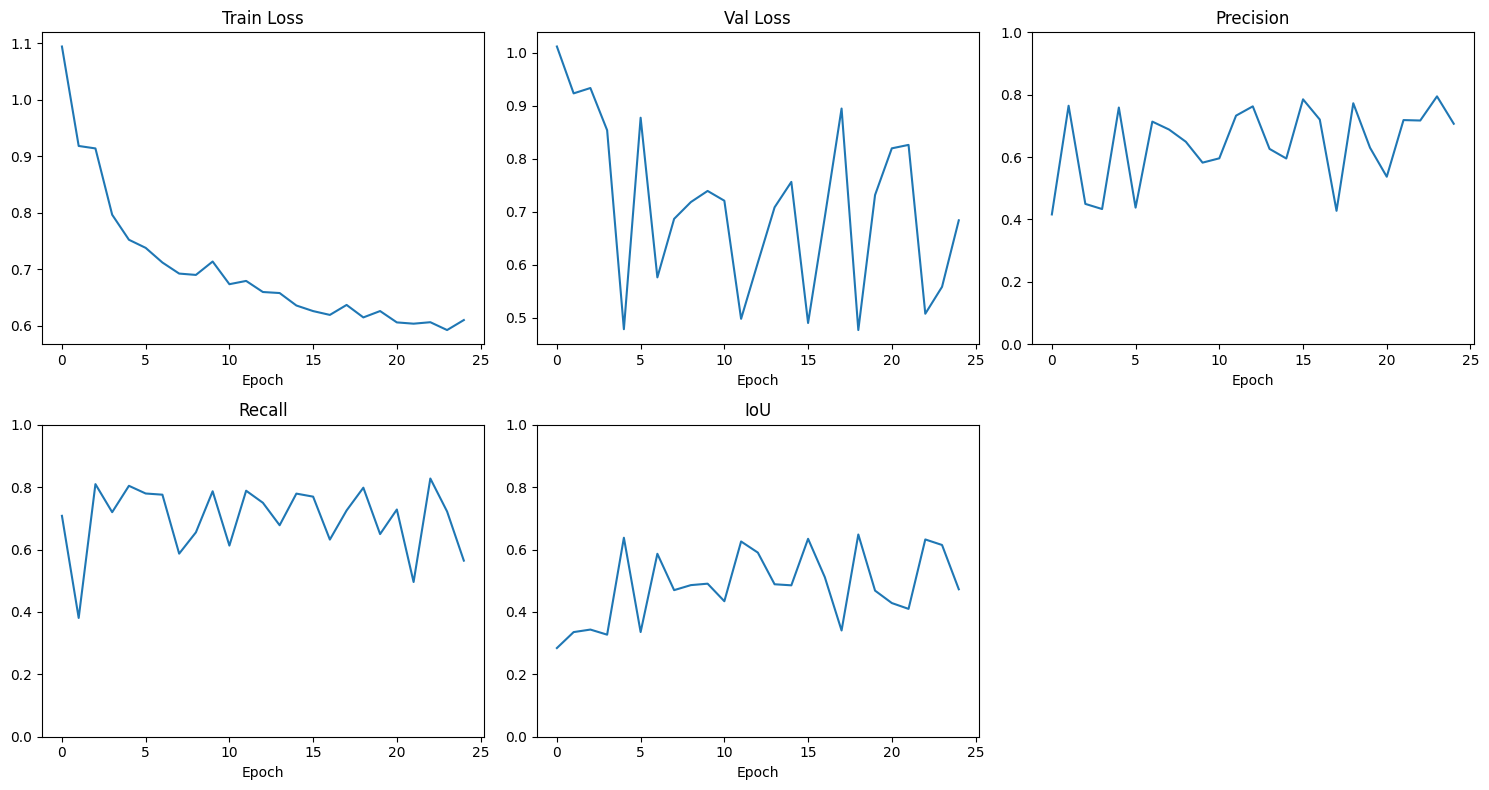

In [ ]:
plot_metrics(
    metrics,
    out_png="/content/drive/MyDrive/IT-geo/SEM_1024_paleorusels_vessels_slice.png",
    out_csv="/content/drive/MyDrive/IT-geo/SEM_1024_paleorusels_vessels_slice.csv"
)


In [ ]:
.

SyntaxError: invalid syntax (ipython-input-1933637684.py, line 1)

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_full_data_10_epochs_model_checkpoint.pth"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Task
```python
def fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, device, num_epochs, threshold=0.5):

    metrics = {
            "Train loss": [],
            "Val loss": [],
            "Precision": [],
            "Recall": [],
            "IoU": []
    }

    best_iou = -1.0 # Initialize best IoU to a very low value
    
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, loss_fn, device, epoch)
        val_metrics = validate_one_epoch(model, val_dataloader, loss_fn, device, epoch, threshold=threshold)

        metrics["Train loss"].append(train_loss)
        metrics["Val loss"].append(val_metrics["loss"])
        metrics["Precision"].append(val_metrics["precision"])
        metrics["Recall"].append(val_metrics["recall"])
        metrics["IoU"].append(val_metrics["iou"])

        print(
            f"\nEPOCH {epoch} | "
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_metrics['loss']:.4f}\n"
            f"Precision: {val_metrics['precision']:.4f} | "
            f"Recall: {val_metrics['recall']:.4f} | "
            f"IoU: {val_metrics['iou']:.4f}"
        )

        # Save the best model
        if val_metrics["iou"] > best_iou:
            best_iou = val_metrics["iou"]
            torch.save(model.state_dict(), "/content/drive/MyDrive/IT-Geo-Paleochannel.pth")
            print(f"Saved best model with IoU: {best_iou:.4f} at epoch {epoch}")

    return metrics

```

```python
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

metrics = fit(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=seg_loss,
    device=device,
    num_epochs=100
)
```

## Modify Fit Function to Save Best Model

### Subtask:
Update the `fit` function to track the best IoU achieved during validation. If the current validation IoU surpasses the best recorded IoU, the model's state dictionary will be saved to `/content/drive/MyDrive/IT-Geo-Paleochannel.pth`. This ensures that only the model with the highest performance is preserved.


**Reasoning**:
I need to modify the existing `fit` function to include logic for tracking the best validation IoU and saving the model's state dictionary when a new best IoU is achieved. This requires redefining the function with the new logic.



In [ ]:
def fit(model, train_dataloader, val_dataloader, optimizer, loss_fn, device, num_epochs, threshold=0.5):

    metrics = {
            "Train loss": [],
            "Val loss": [],
            "Precision": [],
            "Recall": [],
            "IoU": []
    }

    best_iou = -1.0 # Initialize best_iou to a very low value

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_dataloader, optimizer, loss_fn, device, epoch)
        val_metrics = validate_one_epoch(model, val_dataloader, loss_fn, device, epoch, threshold=threshold)

        metrics["Train loss"].append(train_loss)
        metrics["Val loss"].append(val_metrics["loss"])
        metrics["Precision"].append(val_metrics["precision"])
        metrics["Recall"].append(val_metrics["recall"])
        metrics["IoU"].append(val_metrics["iou"])

        # Check if current IoU is better than the best recorded IoU
        if val_metrics['iou'] > best_iou:
            best_iou = val_metrics['iou']
            torch.save(model.state_dict(), "/content/drive/MyDrive/IT-Geo-Paleochannel.pth")
            print(f"--- Model saved: Improved IoU to {best_iou:.4f} at epoch {epoch} ---")

        print(
            f"\nEPOCH {epoch} | "
            f"Train loss: {train_loss:.4f} | "
            f"Val loss: {val_metrics['loss']:.4f}\n"
            f"Precision: {val_metrics['precision']:.4f} | "
            f"Recall: {val_metrics['recall']:.4f} | "
            f"IoU: {val_metrics['iou']:.4f}"
        )

    return metrics

**Reasoning**:
Now that the `fit` function is updated with the model saving logic, I need to call this function to initiate the training process.



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

metrics = fit(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    loss_fn=seg_loss,
    device=device,
    num_epochs=100
)